In [62]:
%run packages.py

In [63]:
from data_import_enginnering import DataImportEnginnering
from metric_selection import Pair_Selection
from data_visualization import Data_Visualization
import importlib

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. DATA

## 1.1. Importation of data into a dictionary

In [64]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
Stock_list = pd.DataFrame(tables[0])
Stock_list.drop(['Security','GICS Sub-Industry','Headquarters Location','CIK','Founded'],axis = 1, inplace=True)
Stock_list['Date added'] = pd.to_datetime(Stock_list['Date added'])
Stock_list = Stock_list[( Stock_list['Date added'] < '2019-12-31') & (Stock_list['Date added']>'2015-01-01')][['Symbol','GICS Sector']]

In [65]:
stock_list = list(Stock_list['Symbol'].unique())
Stock_list_sector = Stock_list.groupby('GICS Sector')['Symbol'].unique().to_dict()
sector_list = list(Stock_list_sector.keys())
pairs = {k:[tuple(sorted((i,j))) for i in Stock_list_sector[k] for j in Stock_list_sector[k] if j!=i] for k in sector_list}
pairs = {k :sorted(list(set(pairs[k]))) for k in sector_list}

In [66]:
start_date = '2018-01-01'
end_date = '2019-12-31'
period = '1d'
colone = ['Close']


In [67]:
Enginner = DataImportEnginnering(stock_list,start_date=start_date,end_date=end_date,period=period,colone=colone)

In [68]:
raw_data = Enginner.RawData()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## 1.2. Normalisation of data

In [69]:
raw_data_normalized = {}
for key, value in raw_data.items():
    raw_data_normalized[key] = Enginner.normalize(value)

raw_data_normalized

{'AOS': Price          Close
 Ticker           AOS
 Date                
 2018-01-02  0.761193
 2018-01-03  0.775195
 2018-01-04  0.786170
 2018-01-05  0.816448
 2018-01-08  0.827801
 ...              ...
 2019-12-23  0.275176
 2019-12-24  0.289247
 2019-12-26  0.298629
 2019-12-27  0.301366
 2019-12-30  0.291984
 
 [502 rows x 1 columns],
 'AMD': Price          Close
 Ticker           AMD
 Date                
 2018-01-02  0.039084
 2018-01-03  0.054447
 2018-01-04  0.069811
 2018-01-05  0.063342
 2018-01-08  0.074124
 ...              ...
 2019-12-23  0.968464
 2019-12-24  0.997574
 2019-12-26  1.000000
 2019-12-27  0.987871
 2019-12-30  0.970081
 
 [502 rows x 1 columns],
 'ALB': Price          Close
 Ticker           ALB
 Date                
 2018-01-02  0.922865
 2018-01-03  0.926253
 2018-01-04  0.905796
 2018-01-05  0.925341
 2018-01-08  1.000000
 ...              ...
 2019-12-23  0.185756
 2019-12-24  0.184273
 2019-12-26  0.186565
 2019-12-27  0.180093
 2019-12-30  0.179014
 

In [70]:
dataframe_normalized = Enginner.Dictionnary_to_Dataframe(raw_data_normalized)
raw_dataframe = Enginner.Dictionnary_to_Dataframe(raw_data)

In [71]:
dataframe_normalized= dataframe_normalized.stack(future_stack=True).stack(future_stack=True).droplevel(level =2).unstack()
raw_dataframe= raw_dataframe.stack(future_stack=True).stack(future_stack=True).droplevel(level =2).unstack()

#### raw_data = first dictionnary with non normalised data for each ticker
#### raw_data_normalized = dictionnary with normalised data
#### raw_dataframe = raw_data into dataframe
#### dataframe_normalized = raw_data_normalized into dataframe

# 2. Pair selection

## 2.1. With Euclidean Distance

In [72]:
Metric = Pair_Selection(dataframe_normalized,number_of_pair=2,stock_list_sector=Stock_list_sector,sector_list=sector_list,sector_neutral = True)

In [73]:
distance = Metric.compute_euclidian_distance()

In [74]:
selected_pairs = Metric.paire_selection(distance,number_of_pair=2,stock_list_sector=Stock_list_sector,sector_list=sector_list,pairs=pairs)

In [75]:
selected_pairs['Energy'] = [selected_pairs['Energy'][0]]
selected_pairs

{'Communication Services': [('FOX', 'FOXA'), ('TMUS', 'LYV')],
 'Consumer Discretionary': [('MGM', 'LKQ'), ('NVR', 'HLT')],
 'Consumer Staples': [('LW', 'CHD'), ('LW', 'KHC')],
 'Energy': [('FANG', 'BKR')],
 'Financials': [('MSCI', 'GPN'), ('GPN', 'CPAY')],
 'Health Care': [('IQV', 'COO'), ('STE', 'IQV')],
 'Industrials': [('TDG', 'CPRT'), ('LDOS', 'CPRT')],
 'Information Technology': [('CDW', 'ANSS'), ('SNPS', 'CDNS')],
 'Materials': [('PKG', 'DOW'), ('DD', 'ALB')],
 'Real Estate': [('UDR', 'O'), ('REG', 'FRT')],
 'Utilities': [('AWK', 'LNT'), ('SRE', 'AWK')]}

In [76]:
data1 = dataframe_normalized.copy()
data2 = raw_dataframe.copy()
# The goal would be to stock every small data frame in a dictionnay to help doing the steps for the reste 
dataframes_dictionnary_norm = {}
dataframes_dictionnary_raw ={}
for sector in sector_list: 
    for value in selected_pairs[sector]:
        
        dataframes_dictionnary_norm[value] = data1[list(value)].copy()
        dataframes_dictionnary_raw[value] = data2[list(value)].copy()

#### dataframes_dictionnary_norm = dictionnary containing normalized data for each of the selected pairs

#### dataframes_dictionnary_raw = dictionnary containing raw data for each of the selected pairs

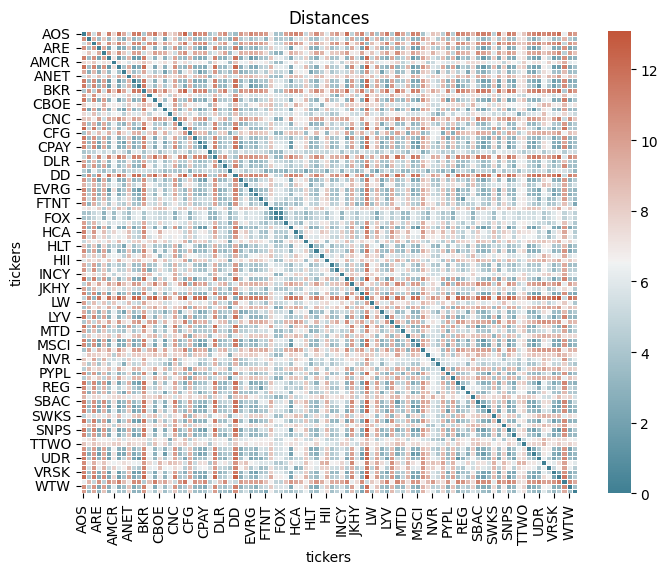

In [77]:
plots = Data_Visualization()
plots.metric(distance, "Distances","tickers","tickers")

In [78]:
plots.pair_historic(dataframes_dictionnary_norm)

## 2.2 Cointegration

In [79]:
pairs_sector_list = [tuple_item for sublist in pairs.values() for tuple_item in sublist]

In [80]:
selected_pairs_2 = Metric.paire_selection_2(pairs_sector_list, p=0.01)
selected_pairs_2

[('LYV', 'TMUS'),
 ('GPN', 'SYF'),
 ('COO', 'IQV'),
 ('CE', 'PKG'),
 ('DLR', 'REG'),
 ('FRT', 'UDR')]

In [81]:
data1 = dataframe_normalized.copy()
data2 = raw_dataframe.copy()
# The goal would be to stock every small data frame in a dictionnay to help doing the steps for the reste 
dataframes_dictionnary_norm_cointegration = {}
dataframes_dictionnary_raw_cointegration ={} 
for pair in selected_pairs_2:
        
    dataframes_dictionnary_norm_cointegration[pair] = data1[list(pair)].copy()
    dataframes_dictionnary_raw_cointegration[pair] = data2[list(pair)].copy()

In [82]:
plots.pair_historic(dataframes_dictionnary_norm_cointegration)

# 3. Computation of spreads

In [83]:
from Spread import Spread


In [84]:
data_viz = Data_Visualization()

In [85]:
for key,values in dataframes_dictionnary_norm.items():

    values.loc[:,'Delta'] = values[key[0]] - values[key[1]]
    values.loc[:,'Delta_norm'] = (values['Delta'] - values['Delta'].mean()) / values['Delta'].std()
    values.drop(['Delta'], axis = 1, inplace=True )

dataframes_dictionnary_norm

{('FOX',
  'FOXA'): Ticker           FOX      FOXA  Delta_norm
 Date                                      
 2018-01-02       NaN       NaN         NaN
 2018-01-03       NaN       NaN         NaN
 2018-01-04       NaN       NaN         NaN
 2018-01-05       NaN       NaN         NaN
 2018-01-08       NaN       NaN         NaN
 ...              ...       ...         ...
 2019-12-23  0.631741  0.666871   -0.879851
 2019-12-24  0.619288  0.652901   -0.828266
 2019-12-26  0.648025  0.677234   -0.678453
 2019-12-27  0.640840  0.662815   -0.432360
 2019-12-30  0.613540  0.633076   -0.349386
 
 [502 rows x 3 columns],
 ('TMUS',
  'LYV'): Ticker          TMUS       LYV  Delta_norm
 Date                                      
 2018-01-02  0.295082  0.163553    1.706945
 2018-01-03  0.280083  0.159762    1.602152
 2018-01-04  0.258807  0.153263    1.463973
 2018-01-05  0.314614  0.181695    1.719944
 2018-01-08  0.332054  0.174384    1.951378
 ...              ...       ...         ...
 2019-12-23

In [86]:
data_viz.spread_plot(dataframes_dictionnary_norm)

# 4. Signal creation

In [87]:
from portfolio import Signaux

In [88]:
"""data = np.array(dataframes_dictionnary_norm[('FOX','FOXA')]['Delta_norm'])
signaux = Signaux(data, 2)
signaux.entry_points_up()"""
for key,value in dataframes_dictionnary_norm.items():
    signaux = Signaux(value.copy(),2)
    value['trading_signals'] = signaux.trading_signals('Delta_norm')
    value['portfolio_units'] = value['trading_signals'].cumsum()

In [ ]:
for key,value in dataframes_dictionnary_norm.items():
    print(key)
    print(value)

In [92]:
data_viz.Entry_trading_points(dataframes_dictionnary_norm)

In [93]:
data_viz.portfolio_units(dataframes_dictionnary_norm)

# 5. Portfolio composition

## Rules :

### - Allocation of 1/n of the capital to each pair, n being the number of pairs

### - Dollar Neutral
Let's say I buy the pair, I buy one unit of asset 1 and sell (price of asset 1/price of asset 2) units of asset 2 (à faire)

### - Stop-loss 
If the level of the spread diverges more than 4 times the threshold, close the trade (à faire)

### - Time-stop
try to test for the time of mean reversion and if the trade is not closed by twice this timeframe, close it (à faire)

### - If all capital in the pair is lost, drop the pair (à faire)

In [ ]:
Capital = 1000000
portfolio = {}
for key,value in dataframes_dictionnary_norm.items():
    portfolio[key] = value
    #portfolio[key] = portfolio[key].drop([key[0],key[1]],axis=1)
    #portfolio[key] = portfolio[key].drop(['Delta_norm','trading_signals'],axis=1)
    #portfolio[key]['Capital'] = Capital/len(dataframes_dictionnary_norm)
    #portfolio[key]['Capital'] = portfolio[key]['Capital']+portfolio[key]['trading_signals']*(-portfolio[key][key[0]]+portfolio[key][key[1]])
    #portfolio[key]['Portfolio'] = portfolio[key]['portfolio_units']*(portfolio[key][key[0]]-portfolio[key][key[1]])

('FOX', 'FOXA')
Ticker           FOX      FOXA  Delta_norm  trading_signals  portfolio_units
Date                                                                        
2018-01-02       NaN       NaN         NaN                0                0
2018-01-03       NaN       NaN         NaN                0                0
2018-01-04       NaN       NaN         NaN                0                0
2018-01-05       NaN       NaN         NaN                0                0
2018-01-08       NaN       NaN         NaN                0                0
...              ...       ...         ...              ...              ...
2019-12-23  0.631741  0.666871   -0.879851                0               -1
2019-12-24  0.619288  0.652901   -0.828266                0               -1
2019-12-26  0.648025  0.677234   -0.678453                0               -1
2019-12-27  0.640840  0.662815   -0.432360                0               -1
2019-12-30  0.613540  0.633076   -0.349386                0 

In [90]:
for key,value in dataframes_dictionnary_raw.items():
    portfolio[key] = portfolio[key].drop([key[0],key[1]],axis=1)
    portfolio[key][key[0]] = value.loc[:,key[0]]
    portfolio[key][key[1]] = value.loc[:,key[1]]
    portfolio[key]['Capital'] = Capital/len(dataframes_dictionnary_norm) + np.cumsum(portfolio[key]['trading_signals']*(-portfolio[key][key[0]]+portfolio[key][key[1]]))
    portfolio[key]['Portfolio'] = portfolio[key]['portfolio_units']*(portfolio[key][key[0]]-portfolio[key][key[1]])

In [91]:
p1 = portfolio
p1

{('FOX',
  'FOXA'): Ticker      Delta_norm  trading_signals  portfolio_units        FOX  \
 Date                                                                  
 2018-01-02         NaN                0                0        NaN   
 2018-01-03         NaN                0                0        NaN   
 2018-01-04         NaN                0                0        NaN   
 2018-01-05         NaN                0                0        NaN   
 2018-01-08         NaN                0                0        NaN   
 ...                ...              ...              ...        ...   
 2019-12-23   -0.879851                0               -1  33.958378   
 2019-12-24   -0.828266                0               -1  33.837860   
 2019-12-26   -0.678453                0               -1  34.115971   
 2019-12-27   -0.432360                0               -1  34.046440   
 2019-12-30   -0.349386                0               -1  33.782230   
 
 Ticker           FOXA       Capital  Portf